<a href="https://colab.research.google.com/github/feiwu77777/Leveraging-Model-Interpretability-and-Stability-to-increase-Model-Robustness/blob/master/conductance%26mutation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Summary**

- 0. Environment setup
  - 0.1 Import
  - 0.2 Util functions
  - 0.3 Downloads
- 1. Load model and dataset
- 2. Calculate conductance and LCR
  - 2.1 Conductance
  - 2.2 LCR
- 3. Training the error predictor
  - 3.1 Preprocess conductance
  - 3.2 Training with conductance
  - 3.3 Training with LCR
  - 3.4 Training with conductance & LCR
  - 3.5 Overview of the 3 training setups
- 4. Other architectures for the error predictor
  - 4.1 Random forest
  - 4.2 LDA & QDA 

## 0. Environment setup

### 0.1 Import

In [0]:
import keras
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras import backend as K
from keras.models import Model, Sequential
from keras.datasets import cifar10
import numpy as np
import os
import keras.backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle
from keras.preprocessing import image

Using TensorFlow backend.


In [0]:
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout, BatchNormalization
from keras.layers import AveragePooling2D, Input, Flatten
from keras.regularizers import l2
import keras
from keras.models import Model, Sequential
from keras import backend as K
import numpy as np
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

### 0.2 Util functions

In [0]:
def resnet_layer(inputs, num_filters: int = 16, kernel_size: int = 3, strides: int = 1, 
                 activation: str = 'relu', batch_normalization: bool = True, conv_first: bool = True):
    """
    Function: helper to the function resnet_v1
    Inputs: layer characteristics
    Outputs: a resnet layer
    """
    conv = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same', 
                  kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape: tuple, depth: int, num_classes: int = 10):
    """
    Function: construct a resnet with specified parameters 
    Inputs: characteristics of the neural network
    Output: the specified neural network
    """

    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
            y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x, num_filters=num_filters, kernel_size=1,
                                 strides=strides, activation=None, batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model



def initialization(model, num_class: int,  inter_layers: list, output_activ: bool):
    """
    function: initialize graph variable to calculate gradients and activations
    inputs: a model
    outputs: initialized graph for activations inside the model
    """
    sess = K.get_session()
    input_tensor = model.layers[0].input
    inter_tensors = [layer.output for layer in inter_layers]
    if output_activ == True:
        out = model.layers[-2].output
        weights, bias = model.layers[-1].weights
        output_tensor = tf.add(tf.matmul(out,weights),bias)
    else:
        output_tensor = model.layers[-2].output
    gradients = [tf.gradients(output_tensor[:,i],inter_tensors) for i in range(num_class)]
    gradients.append(inter_tensors)
    return input_tensor, gradients, sess

def integratedGrad(array, input_tensor, gradients: list, sess, n=10):
    """
    function: preparing left term values of equation (1) of the paper https://arxiv.org/pdf/1910.00387.pdf
    inputs: image array, graph paths: input_tensor and gradients
    outputs: value of the actual activations and gradients for the intermediate images
    """

    reference_value = np.zeros_like(array)
    step_size = (array - reference_value)/float(n)
    intermediate_values = [reference_value + j*step_size for j in range(n+1)] # n+1 inputs to feed the model
    feed_dict = {input_tensor: intermediate_values}
    run_output = sess.run(gradients, feed_dict = feed_dict) #len = 5
    activs = run_output[-1] # len = numLayer # activs[0].shape = (n,128,128,3)
    grads = run_output[:-1] # len = num_class
    return grads, activs



def get_convLayer(model):
    """ return convolutional layers of the input resnet model """

    convLayers = []
    for i in range(len(model.layers)):
        if "add" in model.layers[i].name:
            convLayers.append(model.layers[i+1])
    return convLayers


def getBlocks(convLayers: list):
    """ group layers in convLayers into layer of same channel number """

    convBlocks = []
    debut = 0
    current = convLayers[0].output.shape[-1]
    for i in range(1, len(convLayers)):
        fm_nb = convLayers[i].output.shape[-1]
        if current != fm_nb:
            end = i
            convBlocks.append(convLayers[debut:end])
            debut = end
            current = fm_nb
    end = len(convLayers)
    convBlocks.append(convLayers[debut:end])
    return convBlocks

def calculate_cond(model, x_train: list, train_pred: list, index: int, num_class: int = 10):
    """
    Function: calculate conductance of predictions made a model
    Inputs: the model and predictions it made
    Outputs: conductance values for each prediction
    """

    #get all conv layer in the network
    #for resnet, only the output of resBlocks are considered (skip connection + normal connection)
    convLayers = get_convLayer(model)
                
    #group conv layers by number of channel
    convBlocks = getBlocks(convLayers)
    
    allBlockCond = []
    for block in convBlocks:
        #input_tensor is the input tensor given to the model
        #outputs are gradients and activations associated to the output of block 
        input_tensor, gradients, sess = initialization(model, num_class, block, True)
        originIndex = {}
        conductances = {}

        #iterating over all wrong/correct prediction to calculate their conductance
        for i in tqdm(range(len(index))):
            array = x_train[index[i]]
            pred = train_pred[index[i]]
            #print(i, end = "\r")

            #calculate the gradient of the predicted index wrt to the activation output of block
            grads, activs = integratedGrad(array, input_tensor, [gradients[pred], gradients[-1]], sess)
            grads = np.array(grads)
            activs = np.array(activs)

            #calculate the conductance for neurons/outputs of block
            delta_activs = activs[:,1:,:,:,:] - activs[:,:-1,:,:,:]
            cond = np.sum(grads[:,:,1:,:,:,:]*delta_activs, axis = 2)
            cond = np.mean(cond, axis = (0,2,3)) #averaging over axis 0 for purpose of squeezing

            #store conductance grouped by the class in which the image is predicted
            #originIndex store the original index of the image so its true label can be found
            if pred not in conductances.keys():
                originIndex[pred] = []
                conductances[pred] = []
                originIndex[pred].append(index[i])
                conductances[pred].append(cond)
            else:
                originIndex[pred].append(index[i])
                conductances[pred].append(cond)
                
        allBlockCond.append(conductances)

    #reformatting the conductances of all layers
    conductances = allBlockCond[0]
    for c in range(num_class):
        for i in range(len(conductances[c])):
            conductances[c][i] = list(conductances[c][i])
            for b in range(1, len(convBlocks)):
                conductances[c][i].extend(list(allBlockCond[b][c][i]))

    return conductances, originIndex 
  

def calculate_LCR(model, x_train: list, index: int, model_mutants: list, num_class: int = 10):
    """
    Function: calculate the label change rate of a model using its mutants
    Inputs: a model, its mutants and a training set to evaluate prediction stability
    Outputs: LCR corresponding to each prediction
    """ 
    
    #create a list that map the LCR to the conductance of the good training sample
    L = []
    for c in range(num_class):
        L.append(index[c])
    L = np.concatenate(L, axis = 0)
    
    #reload the orignal model each time else model would be the last mutant
    model.load_weights('cifar10resnet_weights.h5')
    pred = np.argmax(model.predict(x_train[L]), axis = 1)
    LCR = np.zeros(len(pred))
    
    #iterate over mutant to use them to predict x
    for n in range(len(model_mutants)):
        print("---- n="+str(n)+" ----", end = "\r")
        model.set_weights(model_mutants[n])
        mutate_pred = np.argmax(model.predict(x_train[L]), axis = 1)
        difference = mutate_pred != pred
        LCR[difference] += 1
    
    LCR = LCR/len(model_mutants)
    return LCR


def report(testD_res: list, testL: list, thresh: int, Print: bool):
    """ 
    Function: print several performance metrics related to input predictions and labels
    Inputs: prediction, labels and a decision threshold
    Outputs: accuracy and recall scores
    """

    acc = 0
    recallR = 0
    recallW = 0
    nbR = 0
    nbW = 0
    for i in range(len(testL)):
        if testL[i] == 0:
            nbW += 1
            if testD_res[i] < thresh:
                recallW += 1
                acc += 1
        if testL[i] == 1:
            nbR += 1
            if testD_res[i] > thresh:
                recallR += 1
                acc += 1
    acc = acc/len(testD_res)
    recallR, recallW = recallR/nbR, recallW/nbW
    recallM = (recallR + recallW)/2
    if Print == True:
        print("right recall", recallR) 
        print("wrong recall", recallW)  
        print("mean recall", recallM)
        print("accuracy", acc) 
  
    
def help_process_cond(cond_wrongs: dict, layer: int):
    """
    function: helper to the function process_cond, extract conductance of a specified layer.
    inputs: conductances and the layer.
    outputs: conductances of that layer.
    """
    finalWrongs = {}
    for c in sorted(cond_wrongs.keys()):
        cWrongs = []
        for i in range(len(cond_wrongs[c])):
            cWrongs.append(cond_wrongs[c][i][layer].reshape((1,-1)))
        cWrongs = np.concatenate(cWrongs)
        finalWrongs[c] = cWrongs
    return finalWrongs

def process_cond(layers: list, cond_wrongs: dict, concat: int = 0):
    """
    function: extract conductance of specific layers and organize them into tabular data
              where first columns are conductance of the last layers and last columns are conductance
              of the first layers.
    inputs: a list of layers with the first element being the last layer in the model.
    outpus: tabular data version of conductances.
    """
    finalWrongs = help_process_cond(cond_wrongs, layers[0])
    finalWrongs = list(finalWrongs.values())
    finalWrongs = np.concatenate(finalWrongs)

    # include other layers' conductance when concat > 0
    if concat > 0:
        for i in range(concat):
            concatWrongs = help_process_cond(cond_wrongs, layers[i+1])
            concatWrongs = list(concatWrongs.values())
            concatWrongs = np.concatenate(concatWrongs)
            finalWrongs = np.concatenate((finalWrongs, concatWrongs), axis = 1)
    return finalWrongs
            

def error_detector(input_shape: tuple, loss_function: str = 'binary_crossentropy', lr: float = 0.001):
    """ create a binary classifier neural network with specified parameters """

    net = Sequential()    
    net.add(Dense(200, input_shape = (input_shape,), activation = 'relu'))
    net.add(Dropout(0.5))
    net.add(Dense(200, activation = 'relu'))
    net.add(Dropout(0.5))
    net.add(Dense(1, activation = 'sigmoid'))
    opt = keras.optimizers.Adam(lr=lr)
    net.compile(loss=loss_function,optimizer=opt,metrics=None)
    return net


def find_opti_thresh(testL: list, pred: list, plot: bool = True):
    """
    function: using roc curve created from label and prediction, find the threshold that
              minimize the difference of recall score for both classes
    inputs: label testL, predictions pred
    outputs: an optimal threhsold 
    """
    fpr, tpr, thresholds = roc_curve(testL, pred)
    roc_auc = auc(fpr,tpr)
    maxi = 0
    max_ind = 0
    for i in range(len(fpr)):
        s = 1 - fpr[i] + tpr[i]
        if s > maxi:
            maxi = s
            max_ind = i
    if plot == True:
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()
    return thresholds, max_ind, roc_auc
    


from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return 

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,5)),str(round(roc_val,5))),end=100*' '+'\n')
        return roc_val

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

### 0.3 Download model weights, conductance, LCR and others

In [0]:
!wget https://www.dropbox.com/s/4mq461b0prim5d7/cifar10resnet_weights.h5
!wget https://www.dropbox.com/s/axtkrkrwmgpkbqz/cond_rights.p
!wget https://www.dropbox.com/s/z3xxp9g81qez4n4/cond_wrongs.p
!wget https://www.dropbox.com/s/ie5218cmg7qzmg2/cond_test.p
!wget https://www.dropbox.com/s/vv2bm3wx8ff6ytf/originIndex_test.p
!wget https://www.dropbox.com/s/0aso70ux7ko1avn/LCR_test_NAI_0.01.p
!wget https://www.dropbox.com/s/wruvau4v27prc9u/LCRW_NAI_0.01.p
!wget https://www.dropbox.com/s/3dndcwj8yhq46f3/LCRR_NAI_0.01.p
!wget https://www.dropbox.com/s/aepk3tzi8r82hgz/cond_error_detector.h5
!wget https://www.dropbox.com/s/62rl3zdp6gvpnhr/cond%26LCR_error_detector.h5
!wget https://www.dropbox.com/s/akb51d58e22sdin/rnd_split.p

--2020-01-20 09:35:16--  https://www.dropbox.com/s/4mq461b0prim5d7/cifar10resnet_weights.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/4mq461b0prim5d7/cifar10resnet_weights.h5 [following]
--2020-01-20 09:35:21--  https://www.dropbox.com/s/raw/4mq461b0prim5d7/cifar10resnet_weights.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf95e7075e784181ec8cd50c2f9.dl.dropboxusercontent.com/cd/0/inline/AwhTtrBwFN2cGLRV_DftRfcCs43-kJgipgDvkB6a86ud-e1hFxLaXk_4yH1TEo19thDeYGdST27FGzS1gIbZgJelrCy7M7v0PwUrFj-vQ5ErGdWbW7rXJAUFGbKdJvWG72I/file# [following]
--2020-01-20 09:35:21--  https://ucf95e7075e784181ec8cd50c2f9.dl.dropboxusercontent.com/cd/0/inline/AwhTtrBwFN2cGLRV_DftRfcCs43-kJgipgDvkB6a86ud-e1hFxLaXk_4yH1TEo19thDeYGdST27FGz

## 1. Load model and dataset

In [0]:
num_class = 10

index_to_label = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}
label_to_index = {u:v for v,u in index_to_label.items()}
# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_class)
y_test = keras.utils.to_categorical(y_test, num_class)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
model = resnet_v1(input_shape = input_shape, depth = 3*6+2)
model.load_weights('cifar10resnet_weights.h5')

In [0]:
test_pred = np.argmax(model.predict(x_test), axis = 1)

## 2. Calculate conductances and label change rate (LCR)

### 2.1 Conductance

#### 2.1.1 Calculate from scratch the conductances

In [0]:
#train_pred = np.argmax(model.predict(x_train), axis = 1)
#train_label = np.argmax(y_train, axis = 1)

In [0]:
#w = train_pred != train_label
#wrongs_index = np.arange(len(train_pred))[w]
#r = train_pred == train_label
#rights_index = np.arange(len(train_pred))[r]

In [0]:
#cond_wrongs, originIndex_wrongs = calculate_cond(model, x_train, train_pred, wrongs_index)
#cond_rights, originIndex_rights = calculate_cond(model, x_train, train_pred, rights_index)

In [0]:
#cond_test, originIndex_test = calculate_cond(model, x_test, test_pred, np.arange(len(test_pred)))

#### 2.1.2 Load pre-computed conductance

In [0]:
cond_wrongs = pickle.load(open('cond_wrongs.p', 'rb'))
cond_rights = pickle.load(open('cond_rights.p', 'rb'))
cond_test = pickle.load(open('cond_test.p', 'rb'))
originIndex_test = pickle.load(open('originIndex_test.p', 'rb'))

In [0]:
#reorder x_test and y_test following the same order conductance are organized
#originIndex_test = pickle.load(open('test_index.p', 'rb'))
L = []
for c in range(num_class):
    L.append(originIndex_test[c])
#the first values of L are index of x_test whose element are predicted as class 0, then class 1 ... 
L = np.concatenate(L, axis = 0)
x_test = x_test[L]
y_test = y_test[L]
test_pred = test_pred[L]

#rnd_split = np.arange(len(x_test))
#np.random.shuffle(rnd_split)
#pickle.dump(rnd_split, open('rnd_split.p', 'wb'))
rnd_split = pickle.load(open('rnd_split.p', 'rb'))

#the original test set is evenly divided into a new test set and validation set
x_val = x_test[rnd_split[:5000]]
y_val = y_test[rnd_split[:5000]]
x_test = x_test[rnd_split[5000:]]
y_test = y_test[rnd_split[5000:]]
pred_val = test_pred[rnd_split[:5000]]
pred_test = test_pred[rnd_split[5000:]]

### 2.2 LCR

#### 2.2.1 Calculate LCR from scratch

In [0]:
#load the modified version of the model
#model_mutants = pickle.load(open('mutants_NAI_0.01.p', 'rb'))
#LCRW = calculate_LCR(model, x_train, originIndex_wrongs, model_mutants)
#LCRR = calculate_LCR(model, x_train, originIndex_rights, model_mutants)
#LCR_test = calculate_LCR(model, x_test, originIndex_test, model_mutants)

#### 2.2.2 Load pre-computed LCR

In [0]:
LCRW = pickle.load(open('LCRW_NAI_0.01.p', 'rb')).reshape((-1,1))
LCRR = pickle.load(open('LCRR_NAI_0.01.p', 'rb')).reshape((-1,1))

In [0]:
LCR_train = np.concatenate((LCRW, LCRR), axis = 0)
#rnd_split is the same that was used to split the orginal test set of images
LCR_test = pickle.load(open('LCR_test_NAI_0.01.p', 'rb'))
LCR_test = LCR_test.reshape((-1,1))
LCR_val = LCR_test[rnd_split[:5000]]
LCR_test = LCR_test[rnd_split[5000:]]

## 3. Training the error predictor which is a neural network

### 3.1 Preprocess conductance

In [0]:
#get all conv layer in the network
#for resnet, only the output of resBlocks are considered (skip connection + normal connection)
convLayers = []
for i in range(len(model.layers)):
    if "add" in model.layers[i].name:
        convLayers.append(model.layers[i+1])

#select only conductance of the last conv layer if concat = 0
layers = [len(convLayers)-i-1 for i in range(len(convLayers))]
concat = 0
cond_wrongs = process_cond(layers, cond_wrongs, concat)
cond_rights = process_cond(layers, cond_rights, concat)

In [0]:
#training set
trainD = np.concatenate((cond_wrongs,cond_rights), axis = 0)

#normalize cond values
mins = np.min(trainD, axis = 0)
maxs = np.max(trainD, axis = 0)
avgs = np.mean(trainD, axis = 0)
trainD = (trainD - avgs) / (maxs - mins)

#set label for conductances
y_wrongs = np.ones(len(cond_wrongs))
y_rights = np.zeros(len(cond_rights))
trainL = np.concatenate((y_wrongs,y_rights), axis = 0)

In [0]:
testD = process_cond(layers, cond_test, concat)
testD = (testD-avgs)/(maxs-mins)

In [0]:
#rnd_split is the same that was used to split the orginal test set of images
valD = testD[rnd_split[:5000]]
testD = testD[rnd_split[5000:]]

In [0]:
label_val = np.argmax(y_val, axis =1)
valL = pred_val != label_val

### 3.2 Training with only conductance

In [0]:
#create the error detector
classifier = error_detector(trainD.shape[1])

In [0]:
## train the error detector and assess its quality with are under the ROC curve
## not using accuracy here because the dataset is unbalanced

#roc_call = roc_callback(training_data=(trainD, trainL),validation_data=(valD, valL))
#classifier.fit(trainD, trainL, batch_size = 50, validation_data = (valD, valL), epochs = 20, callbacks = [roc_call])

In [0]:
classifier.load_weights('cond_error_detector.h5')

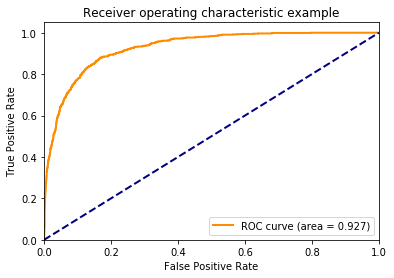

threshold 0.134
auroc 0.927106568189674
right recall 0.8514619883040936
wrong recall 0.8506634499396863
mean recall 0.85106271912189
accuracy 0.8508


In [0]:
#assess the performance of the error detector on the validation set 
#and plot its ROC curve
val_res = classifier.predict(valD)
cond_threshs, cond_ind, cond_auroc = find_opti_thresh(valL, val_res, plot = True)

#choosing the threhold that would optimize the recall on classes of wrong and correct predictions
cond_thresh = cond_threshs[cond_ind-38]
cond_thresh = 1.34e-1

#print the accuracy on the validation set using that threshold
print('threshold', cond_thresh)
print("auroc", cond_auroc)
report(val_res, valL, cond_thresh, True)

In [0]:
#creating the label for conductance of the test set 
label_test = np.argmax(y_test, axis =1)
testL = pred_test != label_test

In [0]:
#test the performance of the error detector on the test set 
#with the threshold chosen from the validation set
test_res = classifier.predict(testD)
report(test_res, testL, cond_thresh, True)

right recall 0.8631346578366446
wrong recall 0.8497801660967269
mean recall 0.8564574119666857
accuracy 0.8522


### 3.3 Training with LCR

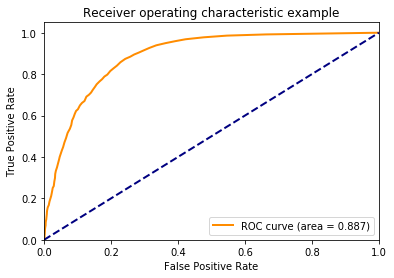

threshold 0.169
auroc 0.8872483581289371
right recall 0.8152046783625732
wrong recall 0.8021712907117008
mean recall 0.808687984537137
accuracy 0.8044


In [0]:
#test the performance of LCR to distinguish wrong and correct predictions and plot the ROC curve
lcr_threshs, lcr_ind, lcr_auroc = find_opti_thresh(valL, LCR_val, plot = True)

#find the optimal threshold
lcr_thresh = lcr_threshs[lcr_ind-4]
lcr_thresh = 0.169

#see result with that treshold on the validation set
print('threshold', lcr_thresh)
print("auroc", lcr_auroc)
report(LCR_val, valL, lcr_thresh, True)

In [0]:
report(LCR_test, testL, lcr_thresh, True)

right recall 0.8410596026490066
wrong recall 0.8060576453346361
mean recall 0.8235586239918213
accuracy 0.8124


### 3.4 Training with conductance and LCR

In [0]:
#combining the output of the binary classifier trained on conductance with LCR
train_res = classifier.predict(trainD)
data = np.concatenate((LCR_train.reshape((-1,1)), train_res), axis = 1)
data_val = np.concatenate((LCR_val.reshape((-1,1)), val_res), axis = 1)
data_test = np.concatenate((LCR_test.reshape((-1,1)), test_res), axis = 1)

In [0]:
#building the unified classifier that take as input LCR and conductance
nn = Sequential()    
nn.add(Dense(10, input_shape = (data.shape[1],), activation = 'relu'))
nn.add(Dense(10, activation = 'relu'))
nn.add(Dropout(0.5))
nn.add(Dense(1, activation = 'sigmoid'))
opt = keras.optimizers.Adam(lr=0.001)
nn.compile(loss = 'binary_crossentropy', optimizer=opt,metrics=None)

In [0]:
## training with focus on the area under the ROC

#roc_call = roc_callback(training_data=(data, trainL),validation_data=(data_val, valL))
#history = nn.fit(data, trainL, validation_data = (data_val, valL), batch_size = 100, epochs = 3, callbacks = [roc_call])

In [0]:
nn.load_weights('cond&LCR_error_detector.h5')

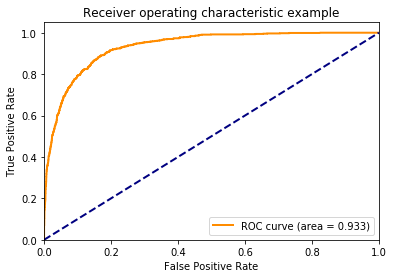

threshold 0.0995
auroc 0.9326943615572909
right recall 0.856140350877193
wrong recall 0.855729794933655
mean recall 0.855935072905424
accuracy 0.8558


In [0]:
#performance assessment
nn_val_res = nn.predict(data_val)
both_threshs, both_ind, both_auroc = find_opti_thresh(valL, nn_val_res, plot = True)

#finding a threshold
both_thresh = both_threshs[both_ind-34]
both_thresh = 9.95e-2

#see result on the validation set
print('threshold', both_thresh)
print("auroc", both_auroc)
report(nn_val_res, valL, both_thresh, True)

In [0]:
#see result on the test set with the chosen threshold
nn_test_res = nn.predict(data_test)
report(nn_test_res, testL, both_thresh, True)

right recall 0.869757174392936
wrong recall 0.8607718612603811
mean recall 0.8652645178266585
accuracy 0.8624


### 3.5 Overview of the error detector performance for all 3 settings of entry data

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
cond_fpr, cond_tpr, cond_threshs = roc_curve(valL, val_res)
lcr_fpr, lcr_tpr, lcr_threshs = roc_curve(valL, LCR_val)
both_fpr, both_tpr, both_threshs = roc_curve(valL, nn_val_res)

In [0]:
both_x, both_y = both_fpr[both_ind-34], both_tpr[both_ind-34]
lcr_x, lcr_y = lcr_fpr[lcr_ind-4], lcr_tpr[lcr_ind-4]
cond_x, cond_y = cond_fpr[cond_ind-34], cond_tpr[cond_ind-38]

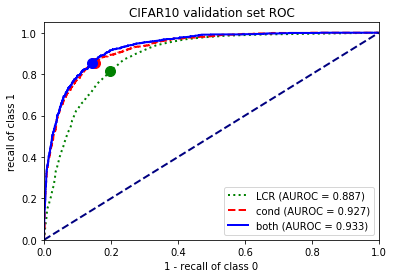

In [0]:
plt.figure()
lw = 2
plt.plot(lcr_fpr, lcr_tpr, ':', color = 'green',
         lw=lw, label='LCR (AUROC = %0.3f)' % lcr_auroc)
plt.plot(lcr_x, lcr_y,marker='o',  markersize=10, color= 'green')
plt.plot(cond_fpr, cond_tpr, '--', color = 'red',
         lw=lw, label='cond (AUROC = %0.3f)' % cond_auroc)
plt.plot(cond_x, cond_y, marker='o',  markersize=10, color= 'red')
plt.plot(both_fpr, both_tpr, color = 'blue',
         lw=lw, label='both (AUROC = %0.3f)' % both_auroc)
plt.plot(both_x, both_y, marker='o',  markersize=10, color= 'blue')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - recall of class 0')
plt.ylabel('recall of class 1')
plt.title('CIFAR10 validation set ROC')
plt.legend(loc="lower right")
plt.savefig('cifar10_roc.pdf', bbox_inches = 'tight')

## 4. Choosing other machine learning classifiers for the error detector

- classifiers are trained with both LCR and conductance

### 4.1 Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier(n_estimators = 100, max_depth=10 ,random_state=0)
clf_RF.fit(data, trainL)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

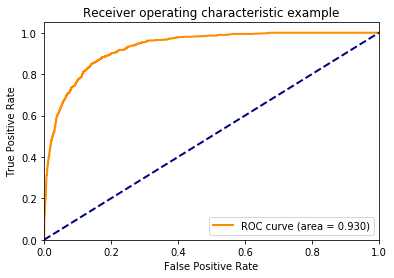

threshold 0.125
auroc 0.9298836758159975
right recall 0.8526315789473684
wrong recall 0.8537997587454764
mean recall 0.8532156688464224
accuracy 0.8536


In [0]:
rf_val_res = clf_RF.predict_proba(data_val)[:,1]
threshs, ind, auroc = find_opti_thresh(valL, rf_val_res, plot = True)
thresh = threshs[ind-45]
thresh = 1.25e-1
print('threshold', thresh)
print("auroc", auroc)
report(rf_val_res, valL, thresh, True)

In [0]:
rf_test_res = clf_RF.predict_proba(data_test)[:,1]
report(rf_test_res, testL, thresh, True)

right recall 0.8554083885209713
wrong recall 0.8575964826575476
mean recall 0.8565024355892594
accuracy 0.8572


### 4.2 LDA & QDA

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
clf_LDA = LDA()
clf_QDA = QDA()
clf_LDA.fit(data, trainL)
clf_QDA.fit(data, trainL)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

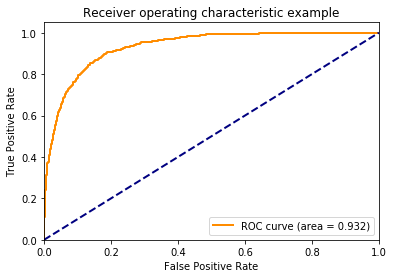

threshold 0.00364
auroc 0.9316668430223125
right recall 0.856140350877193
wrong recall 0.856453558504222
mean recall 0.8562969546907075
accuracy 0.8564


In [0]:
LDA_val_res = clf_LDA.predict_proba(data_val)[:,1]
threshs, ind, auroc = find_opti_thresh(valL, LDA_val_res, plot = True)
thresh = threshs[ind-73]
thresh = 3.64e-3
print('threshold', thresh)
print("auroc", auroc)
report(LDA_val_res, valL, thresh, True)

In [0]:
LDA_test_res = clf_LDA.predict_proba(data_test)[:,1]
report(LDA_test_res, testL, thresh, True)

right recall 0.8620309050772627
wrong recall 0.8585735222276503
mean recall 0.8603022136524565
accuracy 0.8592


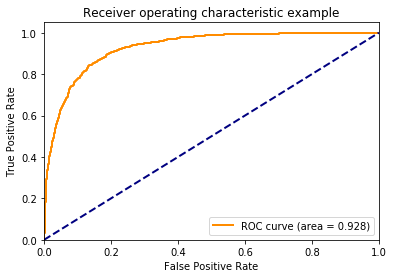

threshold 0.0509
auroc 0.9281476308382536
right recall 0.8538011695906432
wrong recall 0.8537997587454764
mean recall 0.8538004641680599
accuracy 0.8538


In [0]:
QDA_val_res = clf_QDA.predict_proba(data_val)[:,1]
threshs, ind, auroc = find_opti_thresh(valL, QDA_val_res, plot = True)
thresh = threshs[ind]
thresh = 5.09e-2
print('threshold', thresh)
print("auroc", auroc)
report(QDA_val_res, valL, thresh, True)

In [0]:
QDA_test_res = clf_QDA.predict_proba(data_test)[:,1]
report(QDA_test_res, testL, thresh, True)

right recall 0.8443708609271523
wrong recall 0.8612603810454323
mean recall 0.8528156209862923
accuracy 0.8582
